Method 1: train MLP for all unit data samples

Some library imports & data loading functions first. Merging data from all units.

In [314]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from datetime import timedelta, datetime
import warnings
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
Y_LIMS = {
    'rpm': (-20, 1500),
    'motor_voltage': (0, 400),
    'motor_current': (-20, 100),
    'motor_temp': (-20, 250),
    'inlet_temp': (-20, 250),
}
Y_LABEL = 'days_to_failure'
KMEANS_CLUSTER1_TRAIN = [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 16, 17, 18, 19]
KMEANS_CLUSTER2_TRAIN = [2, 8, 9, 14, 15]

def load_unit_data(unit, folder):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    return pd.read_csv("../data/processed/{}/unit{}_rms_anomaly_excluded.csv".format(folder, unit_name), index_col=0)

def get_longest_span():
    spans = []
    for unit in range(0, 20):
        df_unit = load_unit_data(unit, 'train')
        df_unit['timestamp'] = pd.to_datetime(df_unit['timestamp'])
        time_span = max(df_unit['timestamp']) - min(df_unit['timestamp'])
        spans.append(time_span)
    return max(spans)

def load_all_data(units='all'):
    if units == 'all':
        units = range(0, 20)
    df_all = pd.DataFrame()
    for idx, unit in enumerate(units):
        file_name = "../data/processed/train/unit{}_rms_more_features.csv".format("000{}".format(unit) if unit < 10 else "00{}".format(unit))
        file_df = pd.read_csv(file_name, index_col=0)
        file_df['timestamp'] = pd.to_datetime(file_df['timestamp'])
        df_all = df_all.append(file_df)
    return df_all

def get_train_test_sets(df_input, test_size=0.2):
    df_input_features = df_input[df_input.columns[1:]]
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])
    
    train_set, test_set = train_test_split(df_input_features, test_size=test_size, random_state=42)
    x_train = num_pipeline.fit_transform(train_set.drop(columns=[Y_LABEL], axis=1))
    x_test = num_pipeline.fit_transform(test_set.drop(columns=[Y_LABEL], axis=1))
    y_train, y_test = num_pipeline.fit_transform(train_set[[Y_LABEL]]), num_pipeline.fit_transform(test_set[[Y_LABEL]])
    return x_train, x_test, y_train, y_test

def plot_feature_in_df(unit, feature_name, bins=20):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    df_unit = pd.read_csv("../data/processed/train/unit{}_rms_anomaly_excluded.csv".format(unit_name), index_col=0)
    df_unit['timestamp'] = pd.to_datetime(df_unit['timestamp'])
    sns.set()
    fig, axs = plt.subplots(2, 1, figsize=(16, 10))
    ax1 = fig.add_subplot(211)
    ax1.title.set_text(feature_name)
    df_unit.set_index('timestamp', inplace=True)
    df_unit[feature_name].plot(ylim=Y_LIMS[feature_name], label=feature_name)
        
    # plot warnings and errors
    df_alarm = pd.read_csv("../data/raw/train/unit{}_alarms.csv".format(unit_name), header=None, names=['timestamp', 'warning'])
    df_alarm['timestamp'] = pd.to_datetime(df_alarm['timestamp'])
    df_alarm.set_index('timestamp', inplace=True)
    warning_x = df_alarm[df_alarm['warning'] == 'warning'].index.values
    error_x = df_alarm[df_alarm['warning'] == 'error'].index.values
    for warning in warning_x:
        plt.axvline(x=warning, color='orange', alpha=0.3, label='warning')
    for error in error_x:
        plt.axvline(x=error, color='red', alpha=0.7, label='error')
    #plt.legend()
    ax2 = fig.add_subplot(212)
    sns.distplot(df_unit[feature_name], bins=bins)
    ax2.title.set_text(feature_name)
    plt.show()
longest_span = get_longest_span()

Preparing 3 new feature:

1. time remaining until failure (in days)

2. accumulated warnings generated till now

3. accumulated errors generated till now

In [183]:
def prepare_features(folder='train'):
    unit_range = range(0, 20) if folder == 'train' else range(20, 50)
    for unit in unit_range:
        df_unit = load_unit_data(unit, folder)
        df_unit['timestamp'] = pd.to_datetime(df_unit['timestamp'])
        dt_max = df_unit['timestamp'].max()
        unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
        time_diffs, warnings_til_now, errors_til_now = [], [], []
        df_alarm = pd.read_csv("../data/raw/{}/unit{}_alarms.csv".format(folder, unit_name), header=None, names=['timestamp', 'warning'])
        df_alarm['timestamp'] = pd.to_datetime(df_alarm['timestamp'])
        for idx, row in df_unit.iterrows():
            # time diff in days until failure
            time_diff = dt_max - row['timestamp']
            time_diffs.append(divmod(time_diff.total_seconds(), 60)[0] / (60 * 24))

            # num of accumulated warnings/errors before current observation
            df_before = df_alarm[(df_alarm['timestamp'] < row['timestamp'])]
            accum_warnings = len(df_before[df_before['warning'] == 'warning'].index)
            accum_errors = len(df_before[df_before['warning'] == 'error'].index)
            warnings_til_now.append(accum_warnings)
            errors_til_now.append(accum_errors)

        df_unit['hours_to_failure'] = time_diffs
        df_unit['accumulated_warnings'] = warnings_til_now
        df_unit['accumulated_errors'] = errors_til_now
        df_unit.to_csv("../data/processed/{}/unit{}_rms_more_features.csv".format(folder, unit_name))
    print("Done")

Try plotting unit feature trend combining all the warnings & errors generated. (Yellow lines are warnings and red lines are errors)

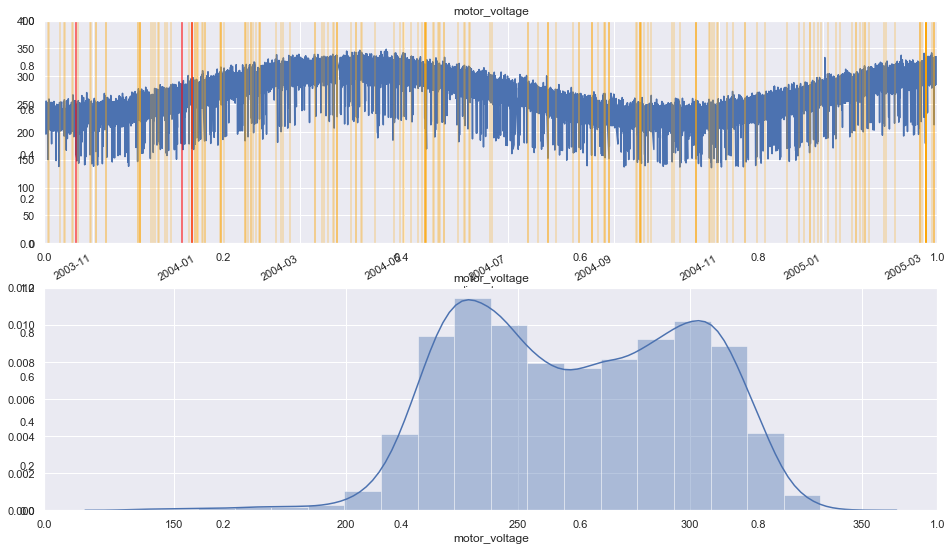

In [247]:
plot_feature_in_df(18, 'motor_voltage', bins=20)

Aggregate and train-test split data of all units, normalizing all inputs and label values.

In [262]:
df_all = load_all_data()
x_train, x_test, y_train, y_test = get_train_test_sets(df_all)
pd.DataFrame(x_train).head()

,0,1,2,3,4,5,6
0,0.239065,1.168622,1.326122,1.615818,1.198051,-0.557166,0.033328
1,-0.973407,-0.953482,-1.255875,-1.305437,-1.312665,-1.135008,-0.730487
2,-0.264047,-0.540065,-0.905974,-0.686892,-0.612556,-1.046109,-0.730487
3,-0.101133,0.118690,0.072858,0.004605,-0.203439,-0.734964,-0.730487
4,0.764433,0.609721,1.054018,1.020061,1.434101,2.732089,1.560960


Distribution of y label values

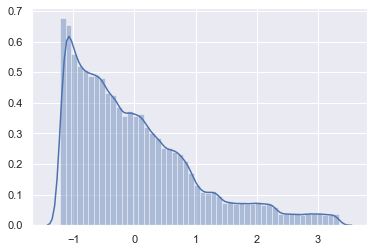

In [253]:
sns.distplot(y_train)

Construct Keras MLP model for data merging all units.

After tons of paramter tuning, it turned out that Dense layers of Lecun normal init and Adadelta optimizer, followed by leaky-ReLU activation outperformed all the other decent options. Model training early stopped at .58 r square, where overfitting began to populate.

Keras model constructed
Train on 668903 samples, validate on 167226 samples
Epoch 1/100
668903/668903 [==============================] - 71s 106us/step - loss: 0.5223 - coeff_determination: 0.4524 - val_loss: 0.4813 - val_coeff_determination: 0.5015
Epoch 2/100
668903/668903 [==============================] - 67s 101us/step - loss: 0.4499 - coeff_determination: 0.5300 - val_loss: 0.4283 - val_coeff_determination: 0.5552
Epoch 3/100
668903/668903 [==============================] - 68s 101us/step - loss: 0.4382 - coeff_determination: 0.5424 - val_loss: 0.4356 - val_coeff_determination: 0.5460
Epoch 4/100
668903/668903 [==============================] - 68s 101us/step - loss: 0.4312 - coeff_determination: 0.5497 - val_loss: 0.4293 - val_coeff_determination: 0.5509
Epoch 5/100
668903/668903 [==============================] - 68s 101us/step - loss: 0.4262 - coeff_determination: 0.5548 - val_loss: 0.4406 - val_coeff_determination: 0.5419
Epoch 6/100
668903/668903 [===========================

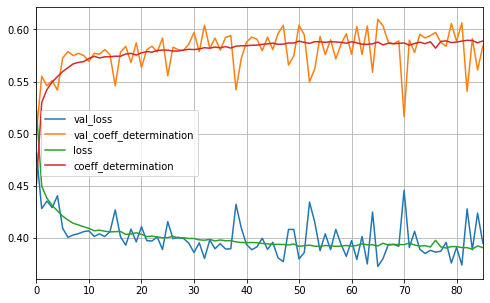

In [64]:
def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

def create_keras_model(optimizer='adam', neuron=50, init='lecun_normal', act_alpha=0.01):
    model_sequences = [
        keras.layers.Dense(units=neuron, kernel_initializer=init, input_shape=x_train.shape[1:]),
        keras.layers.LeakyReLU(alpha=act_alpha)
    ]
    
    for i in range(5):
        model_sequences.append(keras.layers.Dense(units=neuron, kernel_initializer=init,
                                                  input_shape=x_train.shape[1:]))
        model_sequences.append(keras.layers.LeakyReLU(alpha=act_alpha))
        
    #model_sequences.append(keras.layers.BatchNormalization())
    model_sequences.append(Dense(units=1, name='score_output'))
    model_sequences.append(keras.layers.LeakyReLU(alpha=act_alpha))
    #model_sequences.append(keras.layers.Activation(activation))

    nn_model = keras.models.Sequential(model_sequences)
    nn_model.compile(optimizer=optimizer, loss='mse', metrics=[coeff_determination])
    return nn_model

def save_keras_model(model, history, file_name):
    model_json = model.to_json()
    with open("../models/failure_predicting/{}.json".format(file_name), 'w') as json_file:
        json_file.write(model_json)
    model.save_weights("../models/failure_predicting/{}.h5".format(file_name))
    with open('../models/failure_predicting/{}.history'.format(file_name), 'wb') as file_history:
        pickle.dump(history.history, file_history)
    print("model saved")
    
def load_nn_model(model_name):
    with open('../models/failure_predicting/{}.json'.format(model_name)) as f:
        nn_model = model_from_json(f.read())
    nn_model.load_weights('../models/failure_predicting/{}.h5'.format(model_name))
    return nn_model

nn_model = create_keras_model(optimizer='Adadelta', neuron=100, init='lecun_uniform', act_alpha=0.05)
print("Keras model constructed")
early_stopping_cb = EarlyStopping(patience=20)
history = nn_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, callbacks=[early_stopping_cb], verbose=1)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [65]:
save_keras_model(nn_model, history, "overall_100_epoch_es")

model saved


Try to predict units that are most likely to fail.

Prepare the same new features for the test folder first.

In [20]:
prepare_features(folder='test')

Done


Use the trained model to predict the days until failure for new units. Compute the possibility of failure within next 30 days and average failure time predicted by the model on every row.

In [315]:
def get_time_delta_seconds(time_delta):
    return time_delta.seconds + time_delta.days * 86400

def predict_unit(model, unit, delta_days=15):
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    df_pred_unit_original = pd.read_csv("../data/processed/test/unit{}_rms_more_features.csv".format(unit_name), index_col=0)
    nd_pred_unit = num_pipeline.fit_transform(df_pred_unit_original[df_pred_unit_original.columns[1:]])
    predictions_scaled = model.predict(nd_pred_unit)
    
    y_scaler = StandardScaler().fit(df_all[[Y_LABEL]])
    predictions = y_scaler.inverse_transform(predictions_scaled)
    
    every_fail_time = []
    df_pred_unit_original['timestamp'] = pd.to_datetime(df_pred_unit_original['timestamp'])
    date_max = max(df_pred_unit_original['timestamp'])
    predicted_failures = 0
    for num_idx, pred in enumerate(predictions):
        pred = float(predictions[num_idx][0])
        try:
            failure_time = df_pred_unit_original.iloc[num_idx]['timestamp'] + timedelta(days=pred)
        except Exception as ex:
            continue
            #failure_time = df_pred_unit_original.iloc[num_idx]['timestamp'] + longest_span
            
        # predicted to fail within delta_days
        if failure_time <= (date_max + timedelta(days=delta_days)):
            predicted_failures += 1
        every_fail_time.append(failure_time)
    
    date_min, date_max = min(every_fail_time), max(every_fail_time)
    #print('date_min:{}, date_max:{}'.format(date_min, date_max))
    time_deltas = [get_time_delta_seconds(spot - date_min) for spot in every_fail_time]
    avg_time_delta = sum(time_deltas) / len(time_deltas)
    #print("avg_time_delta:{}".format(avg_time_delta))
    final_avg_result = date_min + timedelta(seconds=avg_time_delta)
    #print("unit {} final avg result:{}".format(unit, final_avg_result))
    print("unit {} failure prob:{}, avg:{}".format(unit, float(predicted_failures) / len(predictions), final_avg_result))
    return final_avg_result

In [316]:
nn_model_all = load_nn_model('overall_100_epoch_es')
avg_results = [predict_unit(nn_model_all, unit, delta_days=30) for unit in range(20, 50)]

unit 20 failure prob:0.06843156843156843, avg:2019-10-03 15:18:32.612661403
unit 21 failure prob:0.2760205460935388, avg:2019-02-08 14:06:01.955796418
unit 22 failure prob:0.09267303793802491, avg:2019-02-07 18:50:06.396273013
unit 23 failure prob:0.03668763102725367, avg:2019-06-26 19:56:57.888099598
unit 24 failure prob:0.17623363544813697, avg:2019-01-17 08:56:12.164620844
unit 25 failure prob:0.13747228381374724, avg:2019-05-04 12:01:11.384221335
unit 26 failure prob:0.07357161492303678, avg:2019-07-08 20:32:24.207350602
unit 27 failure prob:0.33719512195121953, avg:2018-11-24 00:49:16.562879155
unit 28 failure prob:0.2938414802540735, avg:2020-11-09 07:10:10.546896258
unit 29 failure prob:0.17654808959156784, avg:2019-05-19 11:00:17.467252224
unit 30 failure prob:0.03748361730013106, avg:2021-02-28 04:59:45.984591665
unit 31 failure prob:0.005494505494505495, avg:2019-12-15 07:13:51.752730261
unit 32 failure prob:0.1703125, avg:2019-07-17 13:51:05.205292370
unit 33 failure prob:0.

From the model predictions, it could be observed that the units with largest failure probability in the next 30 days are:

- unit 39: 0.178

- unit 47: 0.188

- unit 21: 0.276

- unit 28: 0.294

- unit 27: 0.337

- unit 40: 0.349

